### Refactoring Notebook
- This is to verify if we are properly abstracting the functions necessary for Decision Tree Classifier like class probabilities, gini index, and entropy

### Implementing Equation 18.5 

The goal of a Decision Tree is to find feature $j_i$ and threshold $t_i$ that minimizes the weighted sum of the cost of Left Subtree $c(D^L_i(j,t))$ and Right Subtree $c(D^R_i(j,t))$

Or more precisely

$(j_i, t_i) = \arg \min_{j \in \{1,..,D\}} \min_{t \in T_j} \frac{|D^L_i (j,t)|}{|D_i|} c(D^L_i(j,t)) + \frac{|D^R_i (j,t)|}{|D_i|} c(D^R_i(j,t))$

We're implementing the equation above.

### Gini Index 

For classification, we first compute the empirical distribution over class labels for this node: 

$\hat{\pi_{ic}} = \frac{1}{ | D_i |} \sum_{n \in D_i}\mathbb{ I(y_n = c) }$

Given this, we can then compute the **Gini Index**

$G_i = \sum_{c=1}^{C} \hat{\pi_{ic}} (1 - \hat{\pi_{ic}}) = \sum_{c=1}^C \hat{\pi_{ic}} - \sum_{c=1}^C \hat{\pi_{ic}}^2 = 1 - \sum_{c=1} \hat{\pi_{ic}}^2$


In [7]:
from dataclasses import dataclass
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def get_one_hot_encode(y):
    num_categories = np.unique(y).shape[0]
    return np.eye(num_categories)[y], num_categories

def stack_target_wrt_thresh(y_one_hot, unique_thresholds):
    num_thresholds = unique_thresholds.shape[1]
    return np.stack(num_thresholds * [y_one_hot], axis=1)

def get_unique_thresholds(X, feature_index):
    return np.unique(X[:,feature_index]).reshape(1,-1)


def get_left_right_samplers(X, unique_thresholds, feature_index):
    selected_features = X[:, feature_index].reshape(-1,1)
    left_sampler = selected_features <= unique_thresholds
    right_sampler = ~left_sampler
    return left_sampler, right_sampler

def get_class_probabilities(y_one_hot_3d, sampler_mask, num_categories):
    with np.errstate(divide='ignore', invalid='ignore'):
        sampler_mask_3d = np.stack(num_categories * [sampler_mask], axis=2)
        sampled = sampler_mask_3d * y_one_hot_3d
        num_samples = np.sum(sampler_mask, axis=0)
        num_samples = np.stack(num_categories * [ num_samples ], axis=1)
        indicator_sum = np.sum(sampled, axis=0)
        class_probs = np.where(num_samples == 0, 0, indicator_sum / num_samples)
        return class_probs, num_samples 

def get_gini_index(class_probs):
    return 1 - np.sum(class_probs ** 2, axis=1)

def get_entropy(class_probs):
    with np.errstate(divide='ignore', invalid='ignore'):
        inv_prob = np.where(class_probs > 0.0, 1 / class_probs, 0.0)
        log_prob = np.where(inv_prob > 0.0, np.log2(inv_prob), 0.0)
        return np.sum(class_probs * log_prob, axis=1)
    
def get_weighted_sum(left, right, num_samples_left, num_samples_right):
    total_samples = num_samples_left[:,0] + num_samples_right[:,0]
    left_ratio = num_samples_left[:,0] / total_samples
    right_ratio = num_samples_right[:,0] / total_samples
    weighted_sum = left_ratio * left + right_ratio * right
    return weighted_sum

def get_min_threshold_index(weighted_sum):
    return np.argmin(weighted_sum)

def get_partition(sampler, min_threshold_index):
    partition = sampler[:, min_threshold_index]
    partition_count = np.sum(partition)
    return partition, partition_count


In [20]:
data = load_iris()
X,y = data['data'], data['target']


In [26]:
feature_index = 2
unique_thresholds = get_unique_thresholds(X, feature_index)
left_sampler, right_sampler = get_left_right_samplers(X, unique_thresholds, feature_index)
y_one_hot, num_categories = get_one_hot_encode(y)
y_one_hot_3d = stack_target_wrt_thresh(y_one_hot, unique_thresholds)

class_probs_left, num_samples_left = get_class_probabilities(y_one_hot_3d, left_sampler, num_categories)
class_probs_right, num_samples_right = get_class_probabilities(y_one_hot_3d, right_sampler, num_categories)

gini_index_left = get_gini_index(class_probs_left)
gini_index_right = get_gini_index(class_probs_right)

entropy_left = get_entropy(class_probs_left)
entropy_right = get_entropy(class_probs_right)

weighted_gini = get_weighted_sum(gini_index_left, gini_index_right, num_samples_left, num_samples_right)
weighted_entropy = get_weighted_sum(entropy_left, entropy_right, num_samples_left, num_samples_right)

min_threshold_index = get_min_threshold_index(weighted_gini)
left_partition, left_partition_count = get_partition(left_sampler, min_threshold_index)
right_partition, right_partition_count = get_partition(right_sampler, min_threshold_index)
min_cost = weighted_gini[min_threshold_index]


In [28]:
print('unique_thresholds.shape = ', unique_thresholds.shape)
print('left_sampler.shape = ', left_sampler.shape)
print('right_sampler.shape = ', right_sampler.shape)
print('y_one_hot.shape = ', y_one_hot.shape)
print('num_categories = ', num_categories)
print('y_one_hot_3d.shape = ', y_one_hot_3d.shape)

print('class_probs_left.shape = ', class_probs_left.shape)
print('class_probs_right.shape = ', class_probs_right.shape)
print('num_samples_left.shape = ', num_samples_left.shape)
print('num_samples_right.shape = ', num_samples_right.shape)

print('gini_index_left.shape = ', gini_index_left.shape)
print('gini_index_right.shape = ', gini_index_right.shape)

print('entropy_left.shape = ', entropy_left.shape)
print('entropy_right.shape = ', entropy_right.shape)

print('weighted_gini.shape = ', weighted_gini.shape)
print('weighted_entropy.shape = ', weighted_entropy.shape)

print('min_threshold_index = ', min_threshold_index)
print('left_partition.shape = ', left_partition.shape)
print('right_partition.shape = ', right_partition.shape)

print('left_partition_count = ', left_partition_count)
print('right_partition_count = ', right_partition_count)
print('total_count = ', left_partition_count + right_partition_count)

unique_thresholds.shape =  (1, 43)
left_sampler.shape =  (150, 43)
right_sampler.shape =  (150, 43)
y_one_hot.shape =  (150, 3)
num_categories =  3
y_one_hot_3d.shape =  (150, 43, 3)
class_probs_left.shape =  (43, 3)
class_probs_right.shape =  (43, 3)
num_samples_left.shape =  (43, 3)
num_samples_right.shape =  (43, 3)
gini_index_left.shape =  (43,)
gini_index_right.shape =  (43,)
entropy_left.shape =  (43,)
entropy_right.shape =  (43,)
weighted_gini.shape =  (43,)
weighted_entropy.shape =  (43,)
min_threshold_index =  8
left_partition.shape =  (150,)
right_partition.shape =  (150,)
left_partition_count =  50
right_partition_count =  100
total_count =  150


In [12]:
plt.style.use('ggplot')

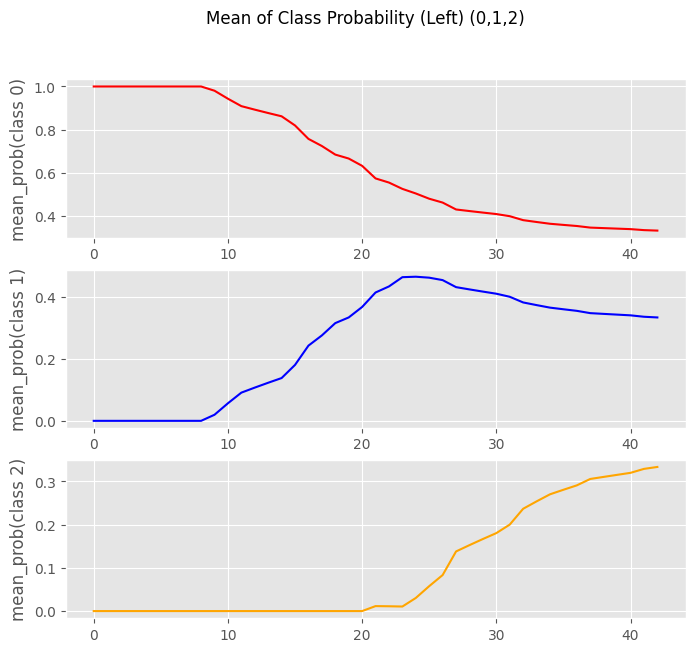

In [13]:
figsize = (8, 7)
fig, (axs1, axs2, axs3) = plt.subplots(3, 1, figsize=figsize)

axs1.plot(np.arange(class_probs_left.shape[0]), class_probs_left[:,0], color='red')
axs1.set_ylabel('mean_prob(class 0)')

axs2.plot(np.arange(class_probs_left.shape[0]), class_probs_left[:,1], color='blue')
axs2.set_ylabel('mean_prob(class 1)')

axs3.plot(np.arange(class_probs_left.shape[0]), class_probs_left[:,2], color='orange')
axs3.set_ylabel('mean_prob(class 2)')

plt.suptitle('Mean of Class Probability (Left) (0,1,2)')
plt.show()

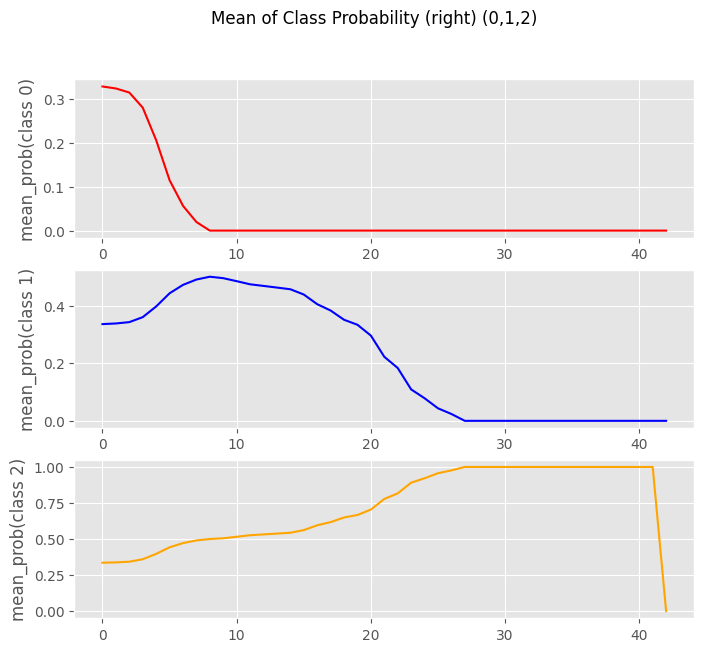

In [14]:
figsize = (8, 7)
fig, (axs1, axs2, axs3) = plt.subplots(3, 1, figsize=figsize)

axs1.plot(np.arange(class_probs_right.shape[0]), class_probs_right[:,0], color='red')
axs1.set_ylabel('mean_prob(class 0)')

axs2.plot(np.arange(class_probs_right.shape[0]), class_probs_right[:,1], color='blue')
axs2.set_ylabel('mean_prob(class 1)')

axs3.plot(np.arange(class_probs_right.shape[0]), class_probs_right[:,2], color='orange')
axs3.set_ylabel('mean_prob(class 2)')

plt.suptitle('Mean of Class Probability (right) (0,1,2)')
plt.show()

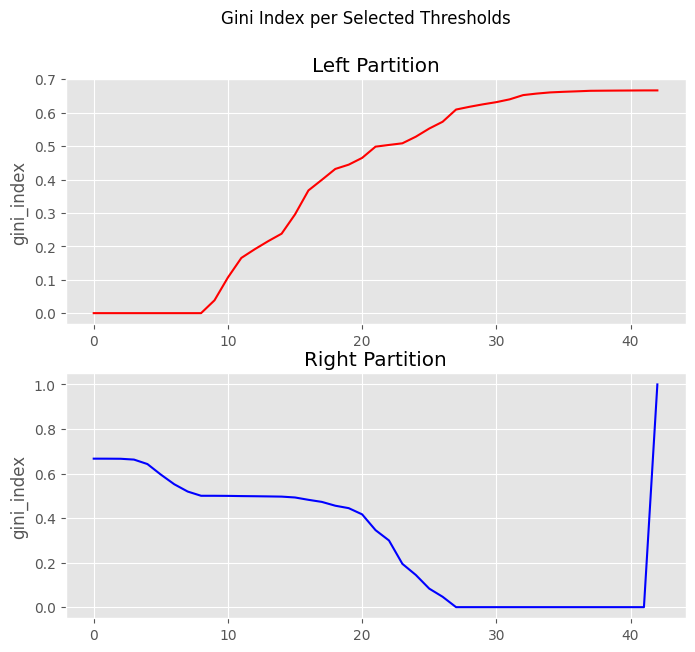

In [15]:
figsize = (8, 7)

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=figsize)
axs1.plot(np.arange(gini_index_left.shape[0]), gini_index_left, color='red')
axs1.set_ylabel('gini_index')
axs1.set_title('Left Partition')

axs2.plot(np.arange(gini_index_right.shape[0]), gini_index_right, color='blue')
axs2.set_ylabel('gini_index')
axs2.set_title('Right Partition')

plt.style.use('ggplot')
plt.suptitle('Gini Index per Selected Thresholds')
plt.show()


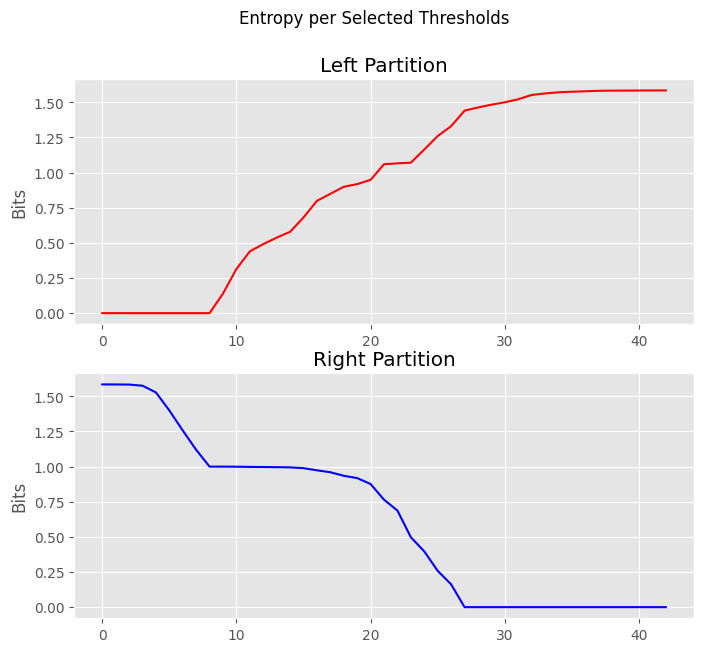

In [16]:
figsize = (8, 7)

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=figsize)
axs1.plot(np.arange(entropy_left.shape[0]), entropy_left, color='red')
axs1.set_ylabel('Bits')
axs1.set_title('Left Partition')

axs2.plot(np.arange(entropy_right.shape[0]), entropy_right, color='blue')
axs2.set_ylabel('Bits')
axs2.set_title('Right Partition')

plt.style.use('ggplot')
plt.suptitle('Entropy per Selected Thresholds')
plt.show()

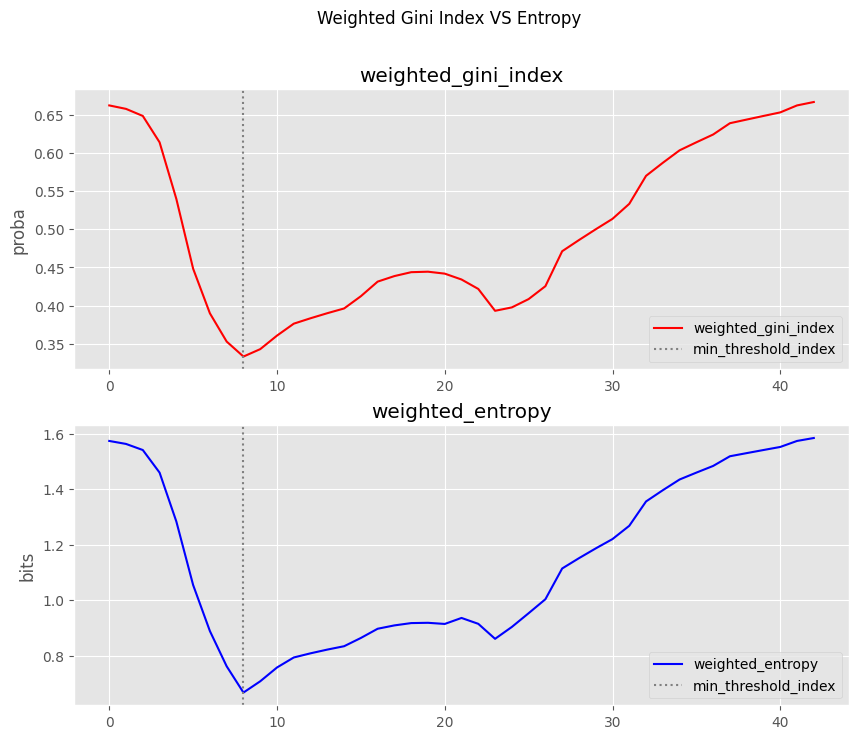

In [33]:
figsize = (10, 8)

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=figsize)
axs1.plot(np.arange(weighted_gini.shape[0]), weighted_gini, color='red', label='weighted_gini_index')
axs1.set_ylabel('proba')
axs1.set_title('weighted_gini_index')
axs1.axvline(min_threshold_index, linestyle='dotted', color='gray', label='min_threshold_index')
axs1.legend()

axs2.plot(np.arange(weighted_entropy.shape[0]), weighted_entropy, color='blue', label='weighted_entropy')
axs2.set_ylabel('bits')
axs2.set_title('weighted_entropy')
axs2.axvline(min_threshold_index, linestyle='dotted', color='gray', label='min_threshold_index')
axs2.legend()

plt.suptitle('Weighted Gini Index VS Entropy')
plt.show()

### Identifying the Proper Inference
- For every downsample, the class prediction per instance will be constantly updated with respect to the node that instance passes through. It will keep assigning predictions until the last piece of subsampled instance, and/or the downstream nodes of Decision Tree runs out.

### Additional Functions
#### Partition Mask
- The partition mask is derived from the threshold that has lowest Gini Index/Entropy. This is expected to be the passed to subsequent nodes to keep reducing the samples as the tree keeps growing.

### num_samples
- In my previous implementation, I was tracking this one. This was used to track the number of leaves. Was this actually optimal?

#### Why left_partitions and right_partions must have the same min_threshold_index?
- If they're not the same, their sampling split symmetry will break. Thus messing up the sampling.